# Adaptive PDE discretizations on cartesian grids
## Volume : Divergence form PDEs
## Part : Applications
## Chapter : Wasserstein distances and Sinkhorn's algorithm

## Problem description

**Schroedinger's entropic relaxation of the optimal transport problem.** 
This notebook is devoted to numerically solving the minimization problem
$$
    \min_\pi \int_{X \times Y} \left( c(x,y) + \epsilon\ln \frac{\pi(x,y)}{e\mu(x) \nu(y)} -\epsilon\right) \,\pi(x,y) \,dx \,dy,
$$
which defines the Wasserstein distance between two probability densities $\mu$ and $\nu$ on spaces $X$ and $Y$. For simplicity, and in view of the numerical implementation, we assume that $X$ and $Y$ are finite.

The unknown density $\pi$, on the product space $X \times Y$, is a coupling between the measures $\mu$ and $\nu$, and is thus subject to the constraints
$$
    \int_X \pi(x,y) dx = \nu(y), \quad \int_Y \pi(x,y) dy = \mu(x),
$$
for all $x \in X$ and $y \in Y$.
Note that the positivity of $\pi(x,y)$, where $\mu(x) \nu(y)$ is positive, is ensured by the presence of the logarithmic term in the optimized functional, and that the marginal constraints ensure that its total mass is one.

**Kantorowich's duality.**
Convex duality yields a maximization problem equivalent to the above minimization
$$
    \max_{\phi,\psi} \int_X \phi(x) \mu(x) dx + \int_Y \psi(y) \nu(y) dy - \epsilon \int_{X\times Y} \mu(x) \nu(y) \exp\left(\frac{\phi(x)+\psi(y)-c(x,y)} \epsilon\right) dx dy,
$$
where $\phi$ and $\psi$ are the Kantorowitch potentials, defined on $X$ and $Y$ respectively.

**Sinkhorn's algorithm.**
Kantorowichs reformulation is an unconstrained concave maximization, w.r.t. two variables $\phi$ and $\psi$.
If one of these two potentials is fixed, say $\psi$, then the corresponding optimal $\phi$ admits the explicit expression
$$
    \phi(x) = -\epsilon \ln \left(\int_Y \nu(y) \exp(\frac{\psi(y) - c(x,y)} \epsilon) dy\right).
$$
Alternate maximization, w.r.t. $\phi$ and $\psi$ successively, is referred to as Sinkhorn's algorithm in this context.

Denoting $\Phi(x) := \exp(\phi(x)/\epsilon)$, $\Psi(y) := \exp(\psi(y)/\epsilon)$ and $K(x,y) = \exp(-c(x,y)/\epsilon)$, one can rephrase the Sinkhorn update (maximization w.r.t $\phi$) as
$$
    \Phi(x)^{-1} = \int_y  K(x,y) \Psi(y) \, \nu(y) dy
$$

***References.***
The implementation presented in this notebook was, in the case of Riemannian metrics (the discussion of Rander metrics is new), first introduced in:  
* Solomon, J., de Goes, F., Peyré, G., Cuturi, M., Butscher, A., Nguyen, A., et al. (2015). Convolutional wasserstein distances: Efficient optimal transportation on geometric domains. ACM Transactions on Graphics (TOG), 34(4), 66.

One of the first numerical implementations of Sinkhorn's algorithm for solving an optimal transport problem is:
* Kosowsky, J. J., & Yuille, A. L. (1994). The invisible hand algorithm: Solving the assignment problem with statistical physics. Neural Networks, 7(3), 477–490.

<!--- Also Gallichon 2009 ? --->

## Distance and distance-squared cost functions

**Linear and quadratic cost.** Assume that $X=Y$ is a metric space. It is common to consider a cost function, in the optimal transport problem, growing as a power of the distance: 
$$
    c(x,y) = d(x,y)^p,
$$
for some exponent $p$. In practice, the distance $d$ is the Euclidean distance on $R^d$, or a Riemannian distance, or possibly a Rander distance.

In this notebook, we focus on two classical choices:
* $p=1$, the linear cost w.r.t distance, is often adequate for *loss functions*, that is measuring the distance between weighted sets. Indeed, the low exponent $p=1$ limits the sensitivity to outliers. The optimal transport cost with $p=1$ is often referred to as the *earth mover distance*. It is an excellent substitute, with typically improved result but a larger computational cost, to Kernel distances or the Haussdorff distance in some variational image processing problems.
* $p=2$, the quadratic cost w.r.t distance, is often adequate for *mapping problems*, that is defining a pairwise matching between sets. Indeed, under adequate assumptions, that the optimal transport problem with this cost uniquely defines such a mapping. 

As a side note, large exponents $p>2$ are excessively sensitive to outliers, exponents $p \in ]0,1[$ raise computational issues due to the concavity of the cost along geodesics, and exponents $p<0$ yield repulsive costs with some applications in quantum mechanics.

**Updating Kantorowitch's potential using Varadhan's formula.**
The main step in Sinkhorn's algorithm is the computation of a convolution
$$
    \Phi(x)^{-1} = \int_Y K(x,y) \Psi(y)\, \nu(y) dy 
$$
where the kernel is 
$$
    K(x,y) = \exp(-\frac {d(x,y)^p}{ \epsilon}).
$$
In the asymptotic regime $\epsilon \to 0$ of vanishing entropy regularization, we can rely on Varadhan's formulas to express this kernel as the fundamental solution to a differential operator, see notebook on [computing distance maps and geodesics using Varadhan's formulas](VaradhanGeodesics.ipynb) and the references above. 

Informally in the case of a Riemannian distance defined by a field of positive definite tensors $M$:
* if $p=1$, then we use the approximation $A \approx u$ where
$$
    u - \epsilon^2 \mathrm{div} (D \nabla u) = B,
$$
and $D := M^{-1}$. A similar approach works for Randers distances, an asymmetric generalization of Riemannian distances, with a [first order term](VaradhanGeodesics.ipynb).
and where the diffusion tensor $D$ and vector field $\omega$ depend on the problem geometry. ($D=M^{-1}$ and $\omega=0$ for a Riemannian metric.)
* if $p=2$ then we use the approximation $A \approx u(\epsilon/4, \cdot)$ where
$$
    \partial_t u = \mathrm{div} (D \nabla u)
$$
and $u(0,\cdot) = B$, with diffusion tensors $D := M^{-1}$.

**Choice of relaxation parameter $\epsilon$.**
Schrodinger's relaxation of optimal transport induces a blurring of the measures over a radius $\sqrt \epsilon$ typically. In order to limit this effect, one would like to choose $\epsilon$ as small as possible. In the implementation presented in this notebook, the main limitation to do so comes from the stability and accuracy of the finite difference schemes used in Varadhan's formulas, which typically require that $\epsilon$ is a few times larger than the gridscale $h$. 

[**Summary**](Summary.ipynb) of volume Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Euclidean distance as cost](#1.-Euclidean-distance-as-cost)
    * [1.1 Linear cost $c(x,y) = \|x-y\|$ (Earth mover distance)](#1.1-Linear-cost-$c(x,y)-=-\|x-y\|$-(Earth-mover-distance))
    * [1.2 Quadratic cost](#1.2-Quadratic-cost)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans, 
and PhD student François Desquilbet, in co-direction with Ludovic Métivier.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.append("../..") # Allow import from parent directory
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Sinkhorn','Div'))

In [1]:
from agd import LinearParallel as lp
from agd import LinearPDE
from agd import FiniteDifferences as fd
from agd import Metrics
from agd.ExportedCode.Notebooks_NonDiv.LinearMonotoneSchemes2D import streamplot_ij
from agd.AutomaticDifferentiation.Optimization import norm_infinity

In [2]:
import numpy as np
import scipy.linalg; import scipy.sparse; import scipy.sparse.linalg 
from matplotlib import pyplot as plt

A few utility functions.

In [3]:
def RangeIndex(rg,x):
    """Find the index of a value x in an equispaced range rg"""
    return int(round( (x-rg[0])/(rg[-1]-rg[0]) * (len(rg)-1)))

def MakeRHS(seed,axes):
    """Put a Dirac mass at the seed point"""
    rhs=np.zeros(tuple(len(ax) for ax in axes))
    rhs[tuple(RangeIndex(ax,x) for ax,x in zip(axes,seed))] = 1
    return rhs

## 1. The 1-Wasserstein distance

As a starter, we solve an optimal transport problem with the Euclidean distance as cost
$$
    c(x,y) = \|x-y\|
$$
A Riemannian distance cost $c(x,y) = d_M(x,y)$ is considered in the end of this section.

**Note on efficiency.**
In the case of this particularly simple cost functions, some substantial speed improvements can be achieved, for instance using fast-Fourier transforms to compute the convolution.


### 1.1 Domain and measures

In [4]:
#Define the domain [0,1]^2, sampled on a cartesian grid
aX,dx = np.linspace(0,1,201,retstep=True)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))
shape = X.shape[1:]

# Define the diffusion tensors (inverse to the metric tensors)
D = fd.as_field(np.eye(2),shape)

Let us generate some source and target measures.

In [5]:
def Gaussian(x,σ,X):
    x,X = fd.common_field((x,X),depths=(1,1))
    return np.exp(- np.sum((X-x)**2,axis=0) / (2*σ**2) ) / (2*np.pi*σ**2)**(len(x)//2)

In [6]:
μ = 2*Gaussian((0.2,0.3),0.1,X) +   Gaussian((0.8,0.7),0.1,X)
ν =   Gaussian((0.8,0.3),0.1,X) + 2*Gaussian((0.4,0.7),0.1,X);

# Alternatives
#μ=Gaussian((0.2,0.3),0.1,X)+Gaussian((0.1,0.8),0.1,X); ν=Gaussian((0.8,0.5),0.2,X); 
#μ=(μ>np.max(μ)/3).astype(float)+1e-6; ν=(ν>np.max(ν)/3).astype(float)+1e-6;

μ,ν = [e/e.sum() for e in (μ,ν)] # Important : normalize the measures

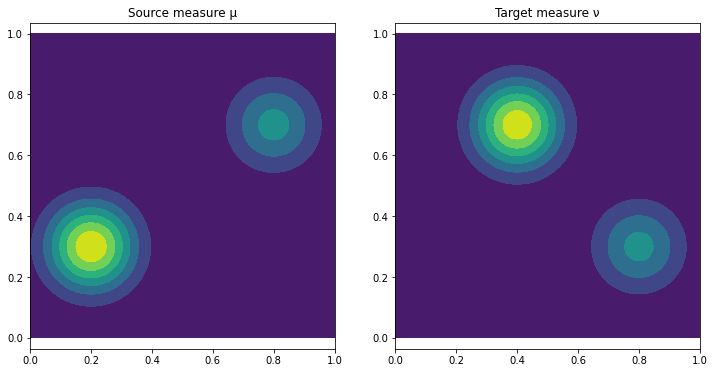

In [7]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1); plt.title("Source measure μ"); plt.axis('equal');
plt.contourf(*X,μ);

plt.subplot(1,2,2); plt.title("Target measure ν"); plt.axis('equal');
plt.contourf(*X,ν);

### 1.2 Convolution kernel (Earth mover distance)

Our first step is to define the domain, and implement the convolution operator appearing in Sinkhorn's algorithm.

<!--- Linear cost $c(x,y) = \|x-y\|$--->

In [9]:
def RiemannConvolution1(D,dx,ϵ):
    """
    Returns a convolution operator defined by 
    f(x) = int_Y exp(-d(x,y)/eps) g(y) dy
    Approximation based on Varadhan's formula.
    """
    # Define PDE operators in Varadhan's formula
    mult = np.ones(D.shape[2:]) 
    
    # Generate the sparse matrix
    triplets = LinearPDE.OperatorMatrix(ϵ**2 * D,
    mult=mult,gridScale=dx,boundaryConditions='Neumann') 
    pde = scipy.sparse.coo_matrix(triplets).tocsc()
    
    # Setup the solver
    solver = scipy.sparse.linalg.factorized(pde)
    convolution = lambda x : solver(x.flatten()).reshape(x.shape) 
    
    return convolution

In [10]:
ϵ = dx
K = RiemannConvolution1(D,dx,ϵ) # Convolution with K(x,y) = exp(-d(x,y)/ϵ)

Let us check that convolution works as expected: we approximate numerically
$$
    K(x,y_0) = \int_Y K(x,y) \delta_{y_0,y} dy
$$
by using a rhs which is a Dirac function located at $y_0$. According to our choice of kernel, one expects
$$
-\epsilon \ln K(x,y_0) \approx C + \|x-y_0\|
$$
where $C$ is a constant.

Reconstructed distance error 0.014384240796172482


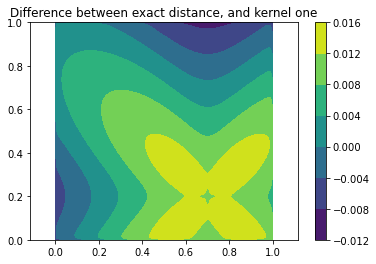

In [11]:
x = [0.7,0.2] # Point from which to compute the distance

# Distance computed from the convolution kernel
rhs = MakeRHS(x,(aX,aX)) # Dirac like mass at x
distK = -ϵ*np.log(K(rhs))

# Euclidean distance computed directly
x_ = fd.as_field(x,X.shape[1:]) # Broadcast
distRef = np.linalg.norm(X-x_,axis=0)

print(f"Reconstructed distance error {norm_infinity(distK-distRef)}")

plt.title("Difference between exact distance, and kernel one"); plt.axis('equal'); 
plt.contourf(*X,distK-distRef);
plt.colorbar();

(0.0, 1.0, 0.0, 1.0)

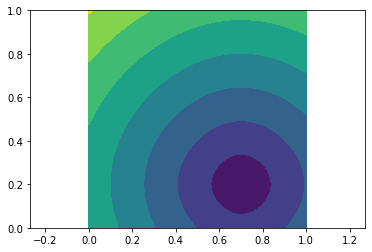

In [13]:
plt.contourf(*X,distK); plt.axis('equal')

### 1.3 Kantorovitch gain and Sinkhorn algorithm

The following function evaluates the value function of the Kantorovitch functional.
$$
    \int_X \phi(x) \mu(x) dx + \int_Y \psi(y) \nu(y) dy 
    {-} \epsilon \int_{X\times Y} \mu(x) \nu(y) \exp\left(\frac{\phi(x)+\psi(y)-c(x,y)} \epsilon\right) dx dy.
$$
For that purpose the integral over the product space $X \times Y$ is reformulated as 
$$
    \int_X \mu(x) \Phi(x) \Big(\int_Y \Psi(y) K(x,y) \nu(y) dy \Big) dy.
$$




*Question 1*
===
Implémenter une estimation de la quantité ci-dessus, le "gain de Kantorovitch".


In [17]:
# Note the exponential kantorovitch potentials are denoted eϕ,eψ.  (eϕ = exp(ϕ/ϵ))
# Indeed capital Φ,Ψ, and small ϕ,ψ,  are hard to distinguish hence bug prone.

def KantorovichGain(eϕ,eψ, μ,ν, Kν,ϵ):
    """
    Input.
    - eϕ,eψ : exponential Kantorovitch potentials
    - μ,ν : reference measures
    - Kν : second convolution operator
    Output.
    - The Kantorovitch gain.
    """
    ϕ,ψ = ϵ*np.log(eϕ), ϵ*np.log(eψ) # TODO
    Z = Kν(eψ*ν)
    gain = (
        (ϕ*μ).sum() # int_X ϕ μ
        + (ψ*ν).sum() # int_Y ψ ν
        - ϵ*(eϕ*μ*Z).sum() # int_X (eϕ μ Z) où Z obtenu par convolution
    )# TODO
    return gain


Next we implement the update to the Kantorowich potentials appearing in Sinkhorn's alternate minimization algorithm.




*Question 2*
===
Implémenter une étape de l'algorithme de Sinkhorn (mise à jour du premier potentiel de Kantorovitch, puis du second).


$$
    \Phi(x)^{-1} = \int_Y K(x,y) \Psi(y) \nu(y) dy
$$

In [15]:
def SinkhornUpdate(eϕ,eψ, μ,ν, Kμ,Kν):
    """
    One full step of Sinkhorn's algorithm, 
    a.k.a alternate minimization of Kantorovitch's energy.
    """
    eϕ = 1/ Kν(eψ*ν) 
    eψ = 1/ Kμ(eϕ*μ)
    return eϕ,eψ


We are all set to solve the optimal transport problem.

In [18]:
eϕ, eψ = np.ones(shape),np.ones(shape) 
for i in range(100):
    if i%10==0: print("Kantorovitch gain : ",KantorovichGain(eϕ,eψ, μ,ν, K,ϵ))
    eϕ, eψ = SinkhornUpdate(eϕ,eψ, μ,ν, K,K)

Kantorovitch gain :  -9.442130941688607e-09
Kantorovitch gain :  0.36595429037399096
Kantorovitch gain :  0.3705975587608822
Kantorovitch gain :  0.37243100645467775
Kantorovitch gain :  0.37317158091316593
Kantorovitch gain :  0.3734728586499686
Kantorovitch gain :  0.37359579877105453
Kantorovitch gain :  0.37364602482028153
Kantorovitch gain :  0.37366655081280686
Kantorovitch gain :  0.373674939047856


In [122]:
def SinkhornSolve(μ,ν,Kμ,Kν,niter=100):
    eϕ = np.ones_like(μ); eψ=eϕ.copy()
    for i in range(niter):
        eϕ,eψ = SinkhornUpdate(eϕ,eψ, μ,ν, Kμ,Kν)
    return eϕ,eψ

### 1.4 The transport flow

The transport plan for the entropic relaxation of the optimal transport problem reads
$$
    \pi(x,y) = \mu(x)\nu(y) \exp( \frac{\phi(x)+\psi(y)-c(x,y)} \epsilon).
$$
In the limit where $\epsilon \to 0$ (which requires a careful analysis, not reproduced here), one has 
$$
    \phi(x)+\psi(y) \leq c(x,y),
$$
with equality almost everywhere on the support of $\pi$.

**Differentiation.** Using the envelope theorem, we obtain (under appropriate assumptions)
$$
    \nabla \phi(x) = \nabla_x c(x,y(x))
$$
where $(x,y(x))$ is in the support of $\pi$. The point $x$ is mapped to $y(x)$ by the optimal transport.

**Case of Wasserstein 1.**
Assume that $c(x,y) = \|x-y\|$, which is the case considered in this section. Then we obtain $\nabla \phi(x) = (x-y(x))/\|x-y(x)\|$, the unit vector from the point $y(x)$ to which $x$ is mapped.

In the case of a Riemannian metric $M$, with inverse tensors $D=M^{-1}$, the direction of the geodesic from $y(x)$ to $x$ is  
$$
    D(x) \nabla \phi(x) = D(x)\nabla_x d_M(x,y(x)).
$$

**Case of Wasserstein 2.**
Assume that $c(x,y) = \frac 1 2 \|x-y\|^2$, which will be considered later. Then we obtain $\nabla \phi(y) = x-y(x)$, the vector from the point $y(x)$ to which $x$ is mapped.

In the case of a Riemannian metric $M$, with inverse tensors $D=M^{-1}$, the vector $\dot x = -D(x) \nabla \phi(x)$ is the initial velocity of a geodesic from $x$ (at $t=0$) to $y(x)$ (at $t=1$). However, these relations cannot be exploited reliably in the numerical solution of the entropic relaxation of optimal transport, due to excessive inaccuracy.





Theorème de l'envelope
$$
    \phi(x) = \sup_y F(x,y)
$$

$$
    \nabla \phi(x) = \nabla F(x,y(x))
$$
où $y(x)$ réalise le maximum.

*Question 3*
===
Implémenter le calcul de du flot $D(x) \nabla \phi(x)$.


In [29]:
def TransportFlow(ψ,D,dx):
    g = np.gradient(ψ,dx)
    return lp.solve_AV(D,g)

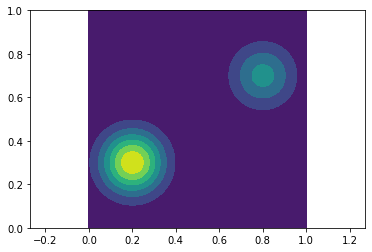

In [24]:
plt.contourf(*X,μ); plt.axis('equal');

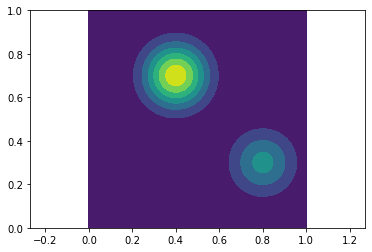

In [25]:
plt.contourf(*X,ν); plt.axis('equal');

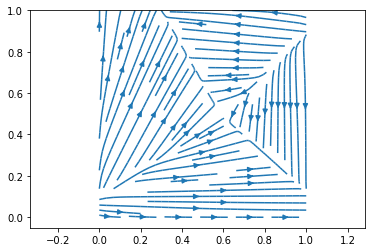

In [31]:
plt.axis('equal')
ψ = ϵ*np.log(eψ)
flow = TransportFlow(ψ,D,dx)
streamplot_ij(*X,*flow);

As expected, the flow has unit euclidean norm, except along singularities of the transport map.

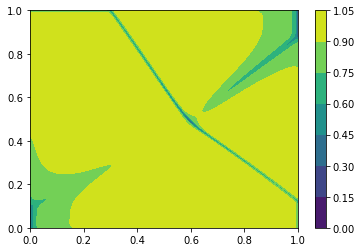

In [32]:
plt.contourf(*X,np.linalg.norm(flow,axis=0)); plt.colorbar()

The flow associated with the other Kantorovitch potential is reversed.

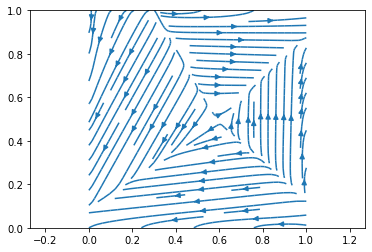

In [21]:
plt.axis('equal')
ϕ = ϵ*np.log(eϕ)
flow = TransportFlow(ϕ,D,dx)
streamplot_ij(*X,*flow);

### 1.4 The transport plan

The optimal transport plan in entropic optimal transport can be expressed in terms of the exponential Kantorovitch potentials 
$$
    \pi(x,y) = \mu(x) \Phi(x) K(x,y) \Psi(y) \nu(y).
$$
It is preferable to avoid full storage of the array $\pi(x,y)$. Indeed, it contains $N_x N_y$ floating point entries, which already in the small case considered here amounts to approximately $13$ gigabytes of data.


**Conditional expectation** Nevertheless, we can compute the conditional expectation of arbitrary function $f : Y \to R$, subject to the coupling defined by $\pi$. More precisely
$$
    E_\pi [f(Y) | X = x] = \frac {\int_Y \pi(x,y) f(y) dy}{\int_Y \pi(x,y) dy} = \Phi(x) \int_Y K(x,y) f(y) \Psi(y) \nu(y) dy,
$$
and the convolution is evaluated as previously by solving an elliptic equation.




*Question 4*
===
Implémenter l'espérance conditionelle $E_\pi [f(Y) | X = x]$.


In [33]:
def CondExpect(f,eϕ,eψ,ν,Kν): 
    """
    Conditional expectation E_pi[f(Y) | X=x], where pi(x,y) 
    is the probability coupling associated with the data.
    """
    return eϕ * Kν(f*eψ*ν) # TODO


As a consistency check, we verify that the conditional expectation of a constant is that constant itself.

In [34]:
CondParams = eϕ,eψ,ν,K
m0 = CondExpect(1.,*CondParams)

print(f"Conditional expectation of 1. found between {np.min(m0)} and {np.max(m0)} (expecting approx 1).")
assert norm_infinity(m0-1.)<0.02

Conditional expectation of 1. found between 0.992923876926507 and 1.013392678697073 (expecting approx 1).


The first moment, namely the conditional expectation $E[Y|X=x]$, is a map from $x$ to the average position of its image by the transport plan $\pi$.

In [35]:
def CondExpectV(f,eϕ,*params):
    """Conditional expectation of a vector function. See CondExpect"""
    return np.array( [CondExpect(fi,eϕ,*params) for fi in f.reshape((-1,*eϕ.shape))]).reshape(f.shape)

In [36]:
m1 = CondExpectV(X,*CondParams)/m0

In [37]:
nsubs=10 # subsampling parameter for plotting
seed = X[:,::nsubs,::nsubs] #.reshape(2,-1)
tip = m1[:,::nsubs,::nsubs] #.reshape(2,-1)
dens = μ[::nsubs,::nsubs].copy(); dens/=np.max(dens)

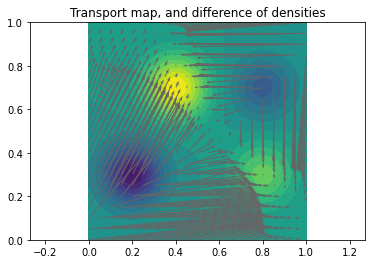

In [38]:
plt.title("Transport map, and difference of densities"); plt.axis('equal')
plt.contourf(*X,ν-μ,levels=20)
plt.quiver(*seed,*(tip-seed),angles='xy',scale_units='xy',scale=1,color="0.4");

### 1.5 Evaluating numerical diffusion

The transport plan $\pi$ is not a one to one map, in the entropic relaxation of the optimal transport problem. It is a slightly diffuse correspondence, whose width is approximately $\sqrt{\epsilon}$, although it is locally influenced by  the  singularities of the transport plan.

In order to illustrate this behavior, we compute the standard deviation
$$
    E_\pi[\|Y-\overline Y\|^2 |X=x] = E_\pi[\|Y\|^2 |X=x] - \|E_\pi[Y |X=x]\|^2,
$$
where $\overline Y$ stands for the conditional expectation $E_\pi[Y |X=x]$.




*Question 5*
===
Calculer la variance du plan de transport $E_\pi[(Y-\overline Y)^2 |X=x]$.


In [41]:
m2 = CondExpect((X**2).sum(axis=0),*CondParams)/m0 # TODO. Second order moment
σ2 = m2-(m1**2).sum(axis=0) # TODO. Variance


In [42]:
assert np.min(σ2)>=0
print(f"Mean standard deviation : {np.mean(np.sqrt(σ2))}")
print(f"Root of relaxtion parameter sqrt(ϵ) : {np.sqrt(ϵ)}")

Mean standard deviation : 0.06696718042055824
Root of relaxtion parameter sqrt(ϵ) : 0.07071067811865475


The standard deviation of the transport map is largest along the singularity where the transport plan splits mass between the two targets.

Standard deviation of the transport map


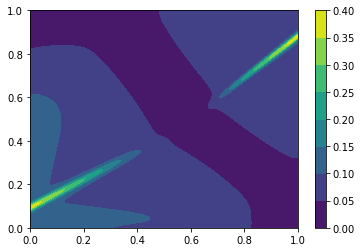

In [43]:
print("Standard deviation of the transport map")
plt.contourf(*X,np.sqrt(σ2)); plt.colorbar();

Another approach is to look at the image of a measure $\lambda$ on $X$ by the transport plan. This defines a measure $\eta$ on $Y$, with
$$
    \eta(y) = 
    \int_X  \pi(x,y) \frac{\lambda(x)}{\mu(x)} dx = 
    \Psi(y) \nu(y) \int_X \Phi(x) K(x,y) \lambda(x) dx,
$$




*Question 6*
===
Implémenter le calcul de la mesure image $\eta$ à partir de $\lambda$.


In [ ]:
def ImageMeasure(λ, eϕ,eψ, Kμ,ν):
    """Image of the measure λ by the transport plan"""
    return # TODO


We choose $\lambda$ as a Dirac mass at selected points, in or our of the singularities of the transport plan.

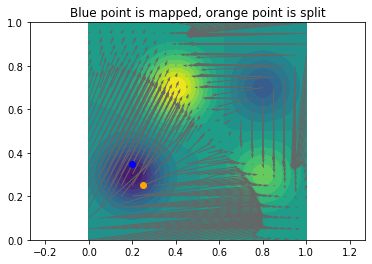

In [32]:
x_mapped = [0.2,0.35]
x_split = [0.25,0.25]

plt.title("Blue point is mapped, orange point is split"); plt.axis('equal')
plt.contourf(*X,ν-μ,levels=20)
plt.quiver(*seed,*(tip-seed),angles='xy',scale_units='xy',scale=1,color="0.4");
plt.scatter(*x_mapped,color='blue')
plt.scatter(*x_split,color='orange');

In [33]:
meas_mapped = ImageMeasure(MakeRHS(x_mapped,(aX,aX)), eϕ,eψ, K,ν)
meas_split  = ImageMeasure(MakeRHS(x_split,(aX,aX)),  eϕ,eψ, K,ν)
assert np.abs(meas_mapped.sum()-1)<0.01
assert np.abs(meas_split.sum() -1)<0.01

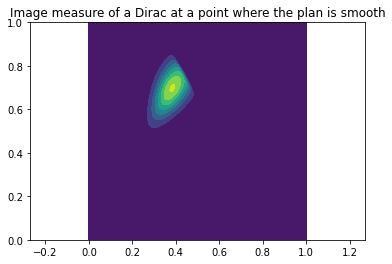

In [34]:
plt.title("Image measure of a Dirac at a point where the plan is smooth"); plt.axis('equal')
plt.contourf(*X,meas_mapped);

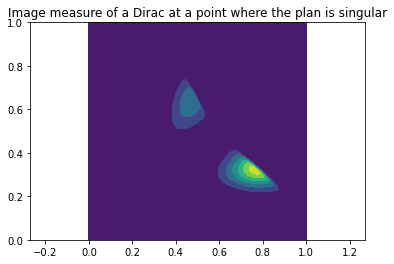

In [35]:
plt.title("Image measure of a Dirac at a point where the plan is singular"); plt.axis('equal');
plt.contourf(*X,meas_split);

In [125]:
del ϵ,dx,D,K,μ,ν,ϕ,ψ,eϕ,eψ,x_mapped,x_split

NameError: name 'K' is not defined

### 1.6 Riemannian distance as cost

We numerically solve the optimal transport problem w.r.t a cost function 
$$
    c(x,y) = d_M(x,y)
$$
where $d_M$ is the Riemannian geodesic distance associated with a field of symmetric positive definite matrices $M$.

As a starter, we set up the domain, metric, and inverse diffusion tensors.

In [387]:
# Create the domain
aX,dx = np.linspace(-1,1,301,retstep=True)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

# Generate the metric
alpha,beta = 0.8,0.5
V = np.ones(X[0].shape),(np.pi/2)*np.cos(4*X[0])
D = Metrics.Riemann.needle(V,alpha,beta).m

In [388]:
ϵ = 2*dx
K = RiemannConvolution1(D,dx,ϵ)

A closely related test case has been considered in a number of other notebooks, illstrating [Riemannian fast marching](../Notebooks_FMM/Riemannian.ipynb), the [Varadhan formula for geodesic distances](VaradhanGeodesics.ipynb), or the [Eulerian discresation of eikonal equations](../Notebooks_NonDiv/EikonalEulerian.ipynb).

However, the anisotropy and frequency of the oscillations are reduced here, in order to help the numerical method (which does struggle).

In [334]:
rhs = MakeRHS([0.,0.], (aX,aX))
distK = -ϵ*np.log(K(rhs))

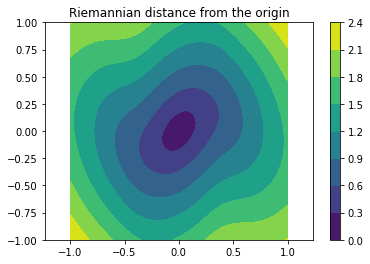

In [335]:
plt.title("Riemannian distance from the origin"); plt.axis('equal')
plt.contourf(*X,distK); plt.colorbar();

We use arbitrary measures on this domain to illustrate optimal transport.

In [336]:
μ = Gaussian((-0.5,0.6),0.3,X); ν = Gaussian((0.7,0.5),0.2,X)+2*Gaussian((0.2,-0.6),0.4,X);
μ/=μ.sum(); ν/=ν.sum()

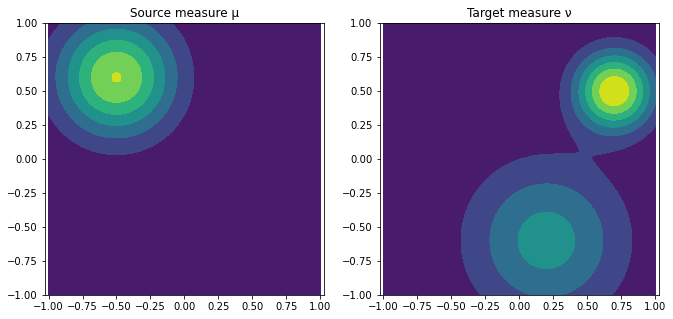

In [337]:
plt.figure(figsize=[11,5])
plt.subplot(1,2,1); plt.title("Source measure μ"); plt.axis('equal'); plt.contourf(*X,μ)
plt.subplot(1,2,2); plt.title("Target measure ν"); plt.axis('equal'); plt.contourf(*X,ν);

Run Sinkhorn's algorithm to compute the Kantorovitch (exponential) potentials, and solve the optimal transport problem.

In [362]:
eϕ,eψ = SinkhornSolve(μ,ν,K,K)

In [363]:
eϕ = 1./K(ν*eψ) # One additional half step

**The transport flow.**

In [340]:
ψ = ϵ*np.log(eψ)
flow = TransportFlow(ψ,D,dx)

The transport flow goes from the source $\mu$ to the target $\nu$, and has an oscillating behavior induced by our choice of metric.

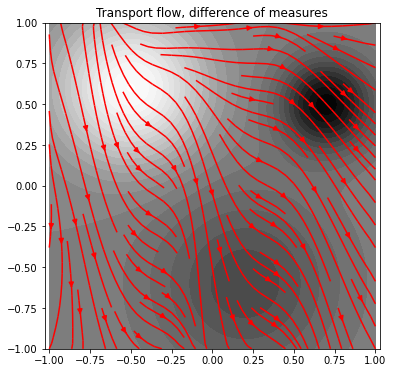

In [341]:
plt.figure(figsize=[6,6]); plt.title("Transport flow, difference of measures");
streamplot_ij(*X,*flow,color='red'); plt.axis('equal')
plt.contourf(*X,ν-μ,levels=30,cmap='Greys');

Another consistency check is that the flow norm is close to $1$, up to (reasonably) small deviations in regions where the metric varies quickly.

In [342]:
gψ = np.array(np.gradient(ψ,dx))
flow_norm = np.sqrt(lp.dot_VAV(gψ,D,gψ))

In [343]:
np.mean(np.abs(flow_norm-1.))

0.03435531389043665

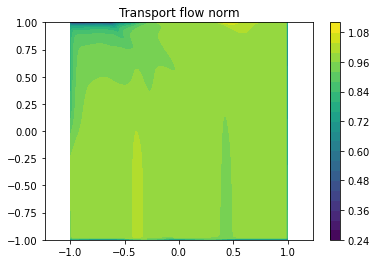

In [361]:
plt.title("Transport flow norm"); plt.axis('equal');
plt.contourf(*X,flow_norm,levels=20); plt.colorbar();

**The transport plan.**

*Disclaimer:* the transport plan obtained in this numerical experiment is subject to a very large numerical diffusion, and obeys the marginal constraints only approximately. It cannot be relied upon in an application, which rather use the entropic Wasserstein 1 optimal transport distance as a similarity measure between distributions. (Often vith debiasing and other ingredients, see the works of Peyre et al.)

In [372]:
CondParams = eϕ,eψ,ν,K

In [373]:
m0 = CondExpect(1.,*CondParams)

In [374]:
np.min(m0),np.max(m0)

(0.9999999999999999, 1.0)

In [375]:
m1 = CondExpectV(X,*CondParams)/m0

In [376]:
nsubs=20 # subsampling parameter for plotting
seed = X[:,::nsubs,::nsubs] #.reshape(2,-1)
tip = m1[:,::nsubs,::nsubs] #.reshape(2,-1)

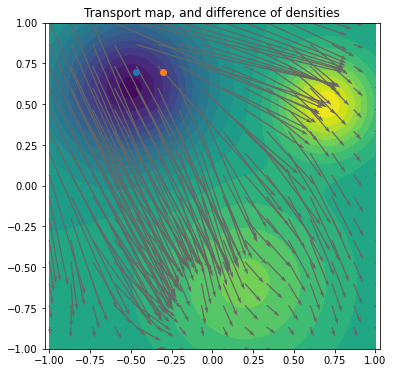

In [377]:
plt.figure(figsize=(6,6)); plt.title("Transport map, and difference of densities"); plt.axis('equal')
plt.contourf(*X,ν-μ,levels=20)
plt.quiver(*seed,*(tip-seed),angles='xy',scale_units='xy',scale=1,color="0.4");

x_mapped = (-0.47,0.7)
x_split  = (-0.3,0.7)
plt.scatter(*x_mapped)
plt.scatter(*x_split);

We numerically compute the image measure of a Dirac mass by the transport plan. 

In [378]:
meas_mapped = ImageMeasure(MakeRHS(x_mapped,(aX,aX)), eϕ,eψ, K,ν)
meas_split  = ImageMeasure(MakeRHS(x_split, (aX,aX)), eϕ,eψ, K,ν)

The image measures should have mass one. Obviously, this is only satisfied very approximately.

In [379]:
np.sum(meas_split),np.sum(meas_mapped)

(1.0294892787496137, 0.266862221596735)

The image measures are very diffuse.

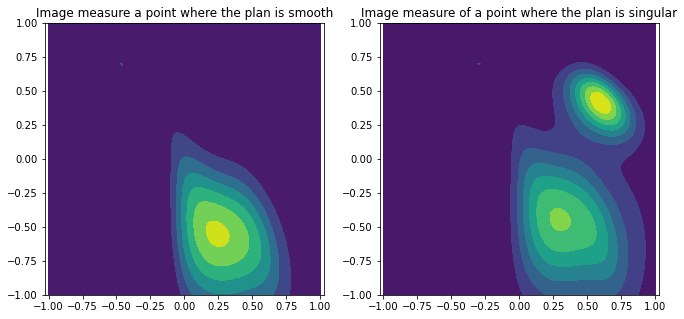

In [386]:
plt.figure(figsize=[11,5])
plt.subplot(1,2,1)
plt.title("Image measure a point where the plan is smooth"); plt.axis('equal')
plt.contourf(*X,meas_mapped)

plt.subplot(1,2,2)
plt.title("Image measure of a point where the plan is singular"); plt.axis('equal')
plt.contourf(*X,meas_split);

In [392]:
del K,ψ,eϕ,eψ

## 2. The 2-Wasserstein distance


*Disclaimer:* the transport plan obtained in this numerical experiment is subject to a very large numerical diffusion, and obeys the marginal constraints only approximately. It cannot be relied upon in an application, which rather use the entropic Wasserstein 1 optimal transport distance as a similarity measure between distributions. (Often vith debiasing and other ingredients, see the works of Peyre et al.)

### 2.1 Convolution kernel




*Question 7*
===
Implémenter l'équation de la chaleur implicite, qui servira de noyau de convolution.


In [ ]:
def RiemannConvolution2(D,dx,ϵ,nsteps=10):
    """
    Convolution with the kernel exp( -d(x,y)**2 / (4*t) ).
    Approximation based on Varadhan's formula, using nsteps
    implicit time steps of time ϵ**2.
    """
    K1 = RiemannConvolution1(D,dx,ϵ)
    def K2(x): 
        # TODO
        return # TODO

    t=# TODO
    return K2, t


In [497]:
D = fd.as_field(np.eye(2),X.shape[1:])
ϵ = 2*dx

In [498]:
K,dt = RiemannConvolution2(D,dx,ϵ,20)

Let us check that the convolution operator reproduces the square euclidean distance.

Reconstructed distance error 0.07998519266487958


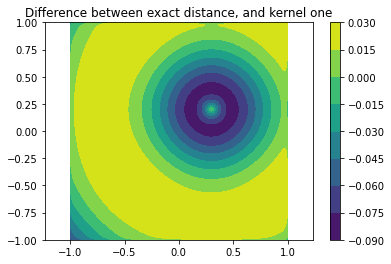

In [509]:
x = [0.3,0.2]

# Distance computed from the convolution kernel
rhs=MakeRHS(x,(aX,aX))
distK = 2*np.sqrt(-4*dt*np.log(K(rhs))) # Not clear why 2
distK-=np.min(distK)

# Euclidean distance computed directly
x_ = fd.as_field(x,X.shape[1:]) # Broadcast
distRef = np.linalg.norm(X-x_,axis=0)

print(f"Reconstructed distance error {norm_infinity(distK-distRef)}")

plt.title("Difference between exact distance, and kernel one"); plt.axis('equal'); 
plt.contourf(*X,distK-distRef); plt.colorbar();

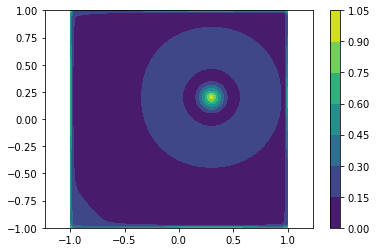

In [510]:
distKnorm = np.linalg.norm(np.gradient(distK,dx),axis=0)
plt.contourf(*X,np.abs(distKnorm-1)); plt.colorbar(); plt.axis('equal');

### 2.2 Sinkhorn algorithm



In [546]:
eϕ,eψ = SinkhornSolve(μ,ν,K,K,niter=40)

For the non-relaxed optimal transport problem in the continuous setting, the Kantorovitch potential is a convex function, whose gradient is the transport map.
However, this relationship cannot be exploited here, due to excessive numerical diffusion.



In [544]:
ψ = dt*np.log(eψ)

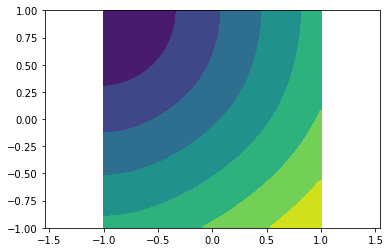

In [545]:
plt.axis('equal'); 
plt.contourf(*X,ψ);

**The transport plan.**

In [520]:
CondParams = eϕ,eψ,ν,K

In [521]:
m0 = CondExpect(1.,*CondParams)

In [522]:
np.min(m0),np.max(m0)

(0.9999992625313032, 1.0000006623931172)

In [523]:
m1 = CondExpectV(X,*CondParams)/m0

In [524]:
nsubs=20 # subsampling parameter for plotting
seed = X[:,::nsubs,::nsubs] #.reshape(2,-1)
tip = m1[:,::nsubs,::nsubs] #.reshape(2,-1)

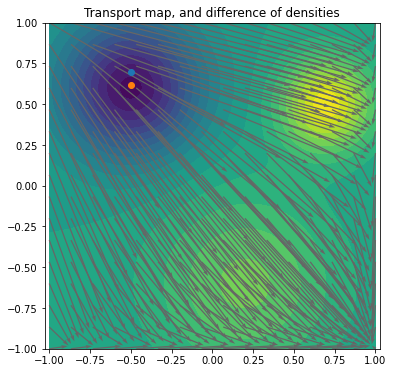

In [533]:
plt.figure(figsize=(6,6)); plt.title("Transport map, and difference of densities"); plt.axis('equal')
plt.contourf(*X,ν-μ,levels=20)
plt.quiver(*seed,*(tip-seed),angles='xy',scale_units='xy',scale=1,color="0.4");

x_mapped = (-0.5,0.7)
x_split  = (-0.5,0.62)
plt.scatter(*x_mapped)
plt.scatter(*x_split);

We numerically compute the image measure of a Dirac mass by the transport plan. 

In [534]:
meas_mapped = ImageMeasure(MakeRHS(x_mapped,(aX,aX)), eϕ,eψ, K,ν)
meas_split  = ImageMeasure(MakeRHS(x_split, (aX,aX)), eϕ,eψ, K,ν)

The image measures are expected to have mass one. 

In [535]:
np.sum(meas_split),np.sum(meas_mapped)

(1.000000003752828, 1.0000002804985875)

The image measures are very diffuse.

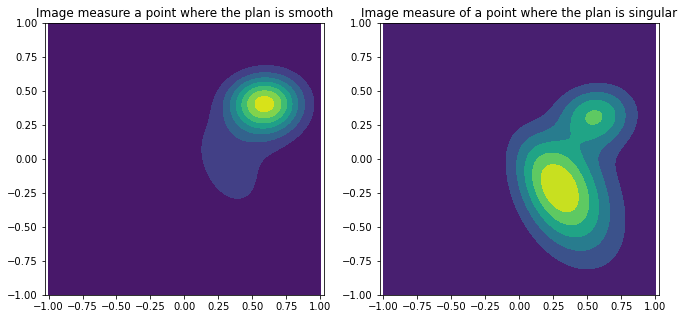

In [536]:
plt.figure(figsize=[11,5])
plt.subplot(1,2,1)
plt.title("Image measure a point where the plan is smooth"); plt.axis('equal')
plt.contourf(*X,meas_mapped)

plt.subplot(1,2,2)
plt.title("Image measure of a point where the plan is singular"); plt.axis('equal')
plt.contourf(*X,meas_split);